In [32]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import random
from PIL import Image

sys.path.append(os.path.abspath(os.path.join("..")))
from src.datasets.huggingfacedataset import HuggingFaceDataset  # noqa: E402

https://huggingface.co/datasets/hammer888/captcha-data

# Label Analysis

In [2]:
raw_dataset = HuggingFaceDataset(
    "/nfs/home/tpz8688/Captcha-Recognition/data/hammer_captchas",
    transform=None,
    preload=False
)

In [3]:
print(f"Number of Images: {len(raw_dataset):,}")

Number of Images: 1,365,874


In [4]:
labels = raw_dataset.labels

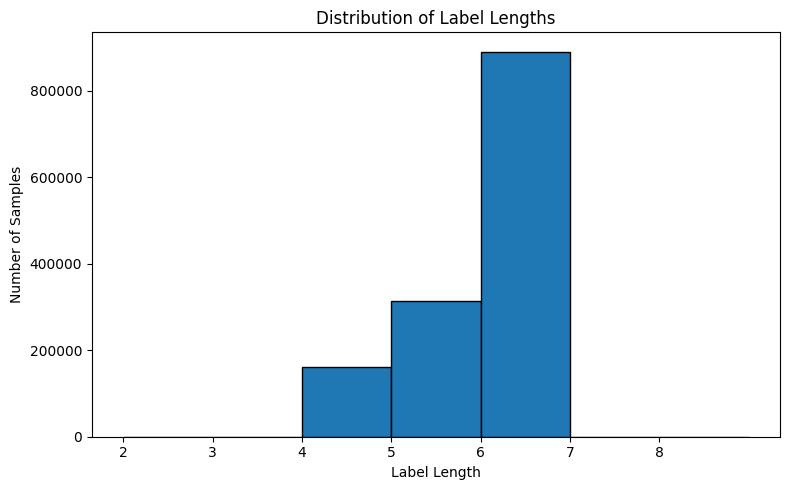

In [5]:
label_lengths = [len(label) for label in labels]

plt.figure(figsize=(8, 5))
plt.hist(label_lengths, bins=range(min(label_lengths), max(label_lengths) + 2), edgecolor="black")
plt.xlabel("Label Length")
plt.ylabel("Number of Samples")
plt.title("Distribution of Label Lengths")
plt.xticks(range(min(label_lengths), max(label_lengths) + 1))
plt.tight_layout()
plt.show()

$\Rightarrow$ Now there are different label lengths

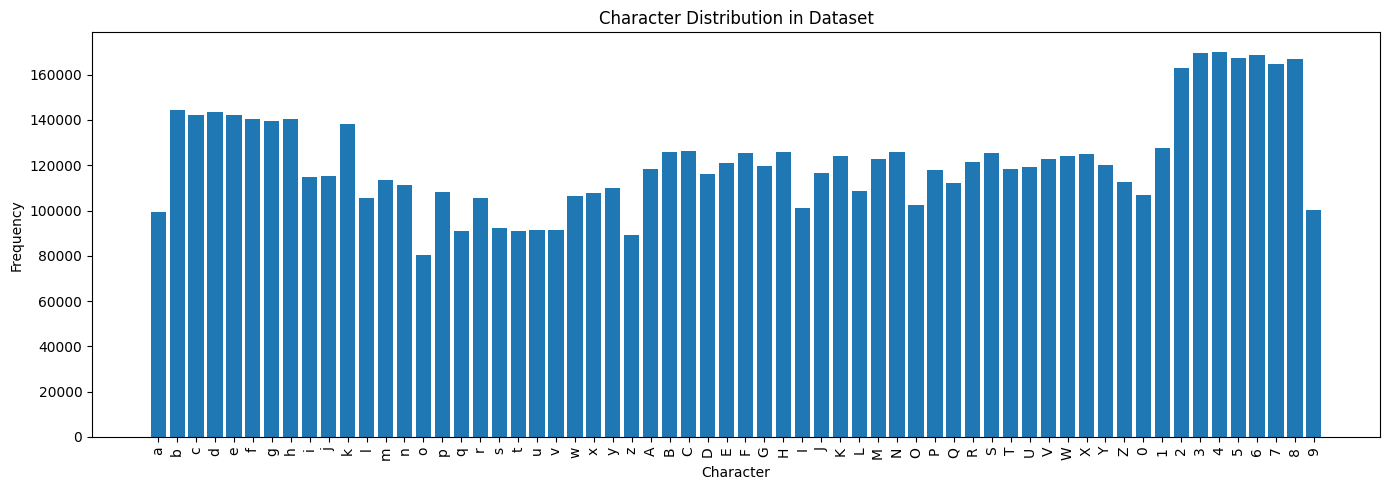

In [6]:
counts = torch.bincount(torch.cat(labels))[1:]
chars = [raw_dataset.idx_to_char[i] for i in range(1, len(counts) + 1)]

plt.figure(figsize=(14, 5))
plt.bar(chars, counts.numpy())
plt.xlabel("Character")
plt.ylabel("Frequency")
plt.title("Character Distribution in Dataset")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

$\Rightarrow$ Here all the characters are present although there seems to be a significant preference for certain characters

# Original Images

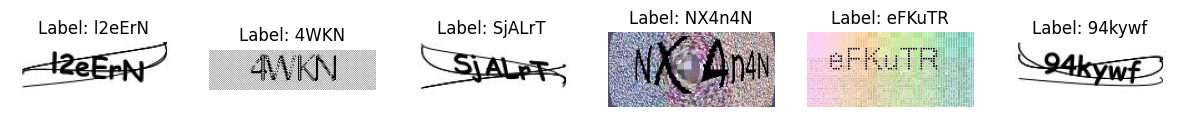

In [7]:
def visualize_samples(dataset, num_samples=6):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    for i in range(num_samples):
        img, label_tensor, _ = dataset[i]
        label_str = "".join(dataset.idx_to_char[idx.item()] for idx in label_tensor)

        img = np.array(img)
        axes[i].imshow(img)

        axes[i].set_title(f"Label: {label_str}")
        axes[i].axis("off")

    plt.show()


visualize_samples(raw_dataset)

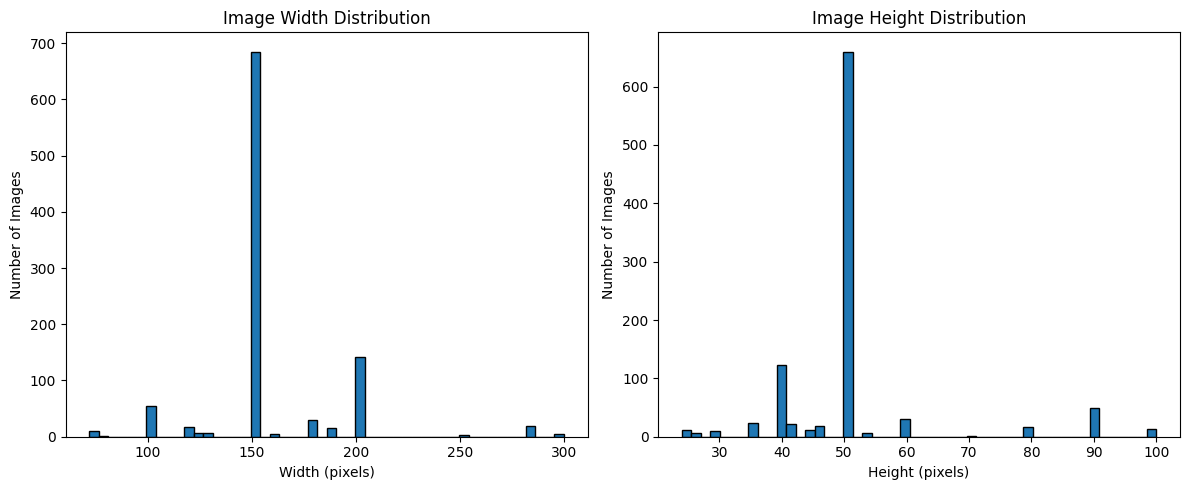

In [8]:
def collect_image_sizes(dataset, sample_size=1000):
    widths = []
    heights = []

    for i in range(len(dataset)):
        img, _, _ = dataset[i]

        # Convert to numpy if needed
        if not isinstance(img, np.ndarray):
            img = np.array(img)

        h, w = img.shape[:2]
        widths.append(w)
        heights.append(h)

        if i == sample_size:
            break

    return widths, heights

widths, heights = collect_image_sizes(raw_dataset)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Width histogram
axes[0].hist(widths, bins=50, edgecolor="black")
axes[0].set_title("Image Width Distribution")
axes[0].set_xlabel("Width (pixels)")
axes[0].set_ylabel("Number of Images")

# Height histogram
axes[1].hist(heights, bins=50, edgecolor="black")
axes[1].set_title("Image Height Distribution")
axes[1].set_xlabel("Height (pixels)")
axes[1].set_ylabel("Number of Images")

plt.tight_layout()
plt.show()

$\Rightarrow$ Images have different dimensions

# Preprocessed Images

In [55]:
preprocess_transformation = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((40, 150)),
        transforms.RandomInvert(p=0.5),
        transforms.ToTensor(),
    ]
)
preprocessed_dataset = HuggingFaceDataset(
    "/nfs/home/tpz8688/Captcha-Recognition/data/hammer_captchas", 
    transform=preprocess_transformation, 
    preload=False
)

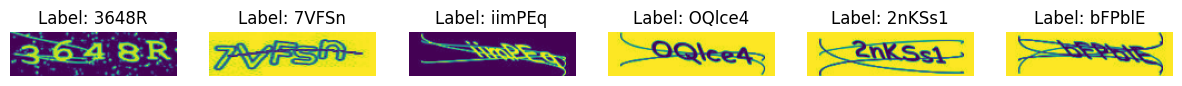

In [58]:
def visualize_samples_preprocessed(dataset, num_samples=6):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    indices = random.sample(range(len(dataset)), k=num_samples)

    for ax, idx in zip(axes, indices):
        img, label_tensor, _ = dataset[idx]
        label_str = "".join(dataset.idx_to_char[i.item()] for i in label_tensor)

        # Normalize image to numpy HWC
        if isinstance(img, Image.Image):
            img = np.array(img)

        elif torch.is_tensor(img):
            if img.ndim == 3:  # (C, H, W)
                img = img.permute(1, 2, 0)
            img = img.cpu().numpy()

        ax.imshow(img)
        ax.set_title(f"Label: {label_str}")
        ax.axis("off")

    plt.show()

visualize_samples_preprocessed(preprocessed_dataset)

In [1]:
# TODO: Find entirely white / black images
# TODO: Find wrongly labeled images